<a href="https://colab.research.google.com/github/colinjhorgan/MLTSAFinalProject/blob/main/Models%20and%20Evaluation/ModelingEval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as plt
from matplotlib import gridspec
%pylab inline

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import cross_val_score, StratifiedKFold as skf, train_test_split as tts
from sklearn.metrics import f1_score, confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from google.colab import drive
drive.mount('/content/gdrive')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Mounted at /content/gdrive


Change directory to location of shared drive


In [ ]:
cd /content/gdrive/MyDrive/3. MSDS Courses/Machine Learning Time Series/MLTSA22 Project

/content/gdrive/.shortcut-targets-by-id/1LVVsMd6gKniMsFyJ0AQvztE0uDjwU-Fo/MLTSA22 Project


In [ ]:
#Read in Features
ecdf_cart_path = 'Data/ECDF_Cartesian.csv'
ecdf_spher_path = 'Data/ECDF_Spherical.csv'
fft_path = 'Data/FFT_features.csv'
time_dom_path = 'Data/Time_Domain_Features.csv'

ecdf_cart = pd.read_csv(ecdf_cart_path)
ecdf_spher = pd.read_csv(ecdf_spher_path)
fft = pd.read_csv(fft_path)
time_dom = pd.read_csv(time_dom_path)

#Read in Cartesian and Spherical CNN 5-Fold F1
cnn_cart_scores = np.load('Data/CNN_5fold_cartesian.npy')
cnn_spher_scores = np.load('Data/CNN_5fold_spherical.npy')

In [ ]:
#Run 5 Fold Cross Validation for KNN across features
np.random.seed(1)

#Define KNN model
model = KNN(n_neighbors=2, weights='distance')

#Cartesian ECDF
ecdf_cart_scores = cross_val_score(model, ecdf_cart.drop(columns='gt'), 
                                   ecdf_cart['gt'],
                                   cv=5,
                                   scoring='f1_weighted')

#Spherical ECDF
ecdf_spher_scores = cross_val_score(model, ecdf_spher.drop(columns='gt'), 
                                   ecdf_spher['gt'],
                                   cv=5,
                                   scoring='f1_weighted')

#Frequency Domain
fft_scores = cross_val_score(model, fft.drop(columns='gt'), 
                                   fft['gt'],
                                   cv=5,
                                   scoring='f1_weighted')

#Time Domain
time_dom_scores = cross_val_score(model, time_dom.drop(columns='gt'), 
                                   time_dom['gt'],
                                   cv=5,
                                   scoring='f1_weighted')
#Combination
combined = pd.concat([ecdf_cart.drop(columns = 'gt'), ecdf_spher.drop(columns = 'gt'), fft.drop(columns = 'gt'), time_dom], axis = 1)
combined_scores = cross_val_score(model, combined.drop(columns = 'gt'), 
                                   combined['gt'],
                                   cv=5,
                                   scoring='f1_weighted')

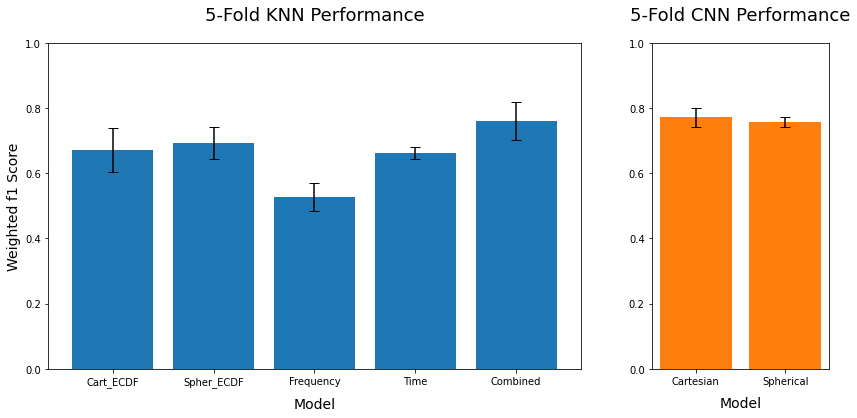

In [ ]:
#Plot KNN and CNN performance
plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1])

#KNN
data = np.array([ecdf_cart_scores, ecdf_spher_scores, fft_scores, time_dom_scores, combined_scores])
x_ticks = ['Cart_ECDF', 'Spher_ECDF', 'Frequency', 'Time', 'Combined']

ax0 = plt.subplot(gs[0])
ax0.bar(x=x_ticks, height=data.mean(axis=1))
ax0.errorbar(x=x_ticks, y=data.mean(axis=1), yerr=data.std(axis=1), 
             color='black', ls=' ', capsize=5)
ax0.set_ylim(0, 1)
ax0.set_xlabel('Model', fontsize=14, labelpad=10)
ax0.set_ylabel('Weighted f1 Score', fontsize=14)
ax0.set_title('5-Fold KNN Performance', fontsize=18, y=1.05);

#CNN
cnn_list = ['Cartesian','Spherical']
means = [cnn_cart_scores.mean(), cnn_spher_scores.mean()]
stds = [cnn_cart_scores.std(), cnn_spher_scores.std()]

ax1 = plt.subplot(gs[1])
ax1.bar(x=cnn_list, height=means, color='tab:orange')
ax1.errorbar(x=cnn_list, y=means, yerr=stds, ls=' ', capsize=5, color='black')
ax1.set_ylim(0,1)
ax1.set_xlabel('Model', fontsize=14, labelpad=10)
ax1.set_ylabel('')
ax1.set_title('5-Fold CNN Performance', fontsize=18, y=1.05);

0.7791521148164025


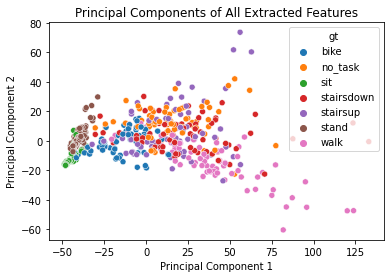

In [ ]:
pca_object = PCA(n_components = 2)
transformed_object  = pd.DataFrame(pca_object.fit(combined.drop(columns = 'gt')).transform(combined.drop(columns = 'gt')))
transformed_object['gt'] = combined['gt']
sns.scatterplot(transformed_object[0],transformed_object[1], hue = transformed_object['gt'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Components of All Extracted Features')
print(sum(pca_object.explained_variance_ratio_))



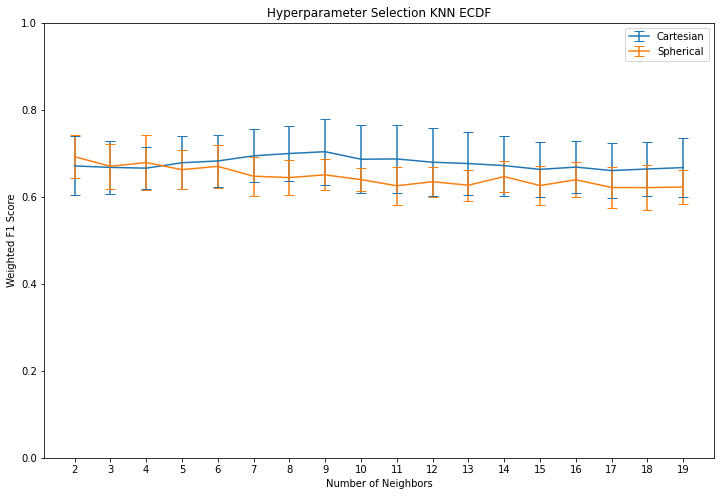

In [ ]:
#ECDF Hyperparameter Selection
#Cartesian
scores_mean = []
scores_std = []
for n in range(2,20):
  model = KNN(n_neighbors=n, weights='distance')
  ecdf_cart_scores = cross_val_score(model, ecdf_cart.drop(columns='gt'), 
                                    ecdf_cart['gt'],
                                    cv=5,
                                    scoring='f1_weighted')
  scores_mean.append(ecdf_cart_scores.mean())
  scores_std.append(ecdf_cart_scores.std())

plt.figure(figsize=(12,8))
plt.errorbar(x=range(2,20), y=scores_mean, yerr=scores_std, capsize=5,
              label='Cartesian')
plt.xlabel('Number of Neighbors')
plt.ylabel('Weighted F1 Score')
plt.title('Hyperparameter Selection KNN ECDF')  

#Spherical
scores_mean = []
scores_std = []
for n in range(2,20):
  model = KNN(n_neighbors=n, weights='distance')
  ecdf_cart_scores = cross_val_score(model, ecdf_spher.drop(columns='gt'), 
                                    ecdf_cart['gt'],
                                    cv=5,
                                    scoring='f1_weighted')
  scores_mean.append(ecdf_cart_scores.mean())
  scores_std.append(ecdf_cart_scores.std())

plt.errorbar(x=range(2,20), y=scores_mean, yerr=scores_std, capsize=5,
              label='Spherical')
plt.ylim(0,1)
plt.xticks(ticks=range(2,20))
plt.legend();

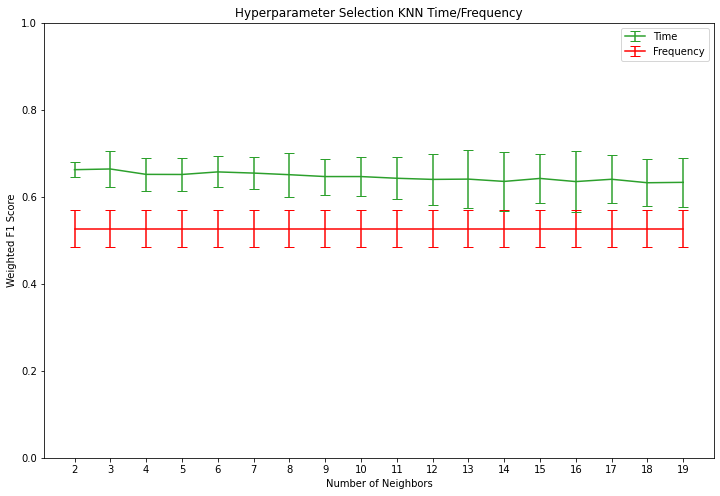

In [ ]:
#ECDF Hyperparameter Selection
np.random.seed(1)
#Time
scores_mean = []
scores_std = []
for n in range(2,20):
  model = KNN(n_neighbors=n, weights='distance')
  time_dom_scores = cross_val_score(model, time_dom.drop(columns='gt'), 
                                    time_dom['gt'],
                                    cv=5,
                                    scoring='f1_weighted')
  scores_mean.append(time_dom_scores.mean())
  scores_std.append(time_dom_scores.std())

plt.figure(figsize=(12,8))
plt.errorbar(x=range(2,20), y=scores_mean, yerr=scores_std, capsize=5,
              label='Time', color='tab:green')
plt.xlabel('Number of Neighbors')
plt.ylabel('Weighted F1 Score')
plt.title('Hyperparameter Selection KNN Time/Frequency')  

#Frequency
scores_mean = []
scores_std = []
for n in range(2,20):
  model = KNN(n_neighbors=n, weights='distance')
  ecdf_cart_scores = cross_val_score(model, fft.drop(columns='gt'), 
                                    fft['gt'],
                                    cv=5,
                                    scoring='f1_weighted')
  scores_mean.append(fft_scores.mean())
  scores_std.append(fft_scores.std())

plt.errorbar(x=range(2,20), y=scores_mean, yerr=scores_std, capsize=5,
              label='Frequency', color='red')
plt.ylim(0,1)
plt.xticks(ticks=range(2,20))
plt.legend();

In [ ]:
#Confusion Matrices for KNN

def conf_mat_plot(df, title):
  '''
  Generates confusion matrix plot for KNN (k=2), using 90-10 train test split
  '''
  X, y = df.drop(columns='gt'), df['gt']
  X_train, X_test, y_train, y_test = tts(X, y, test_size=.1, stratify=y)

  model = KNN(n_neighbors=2, weights='distance')
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  labels = y_test.unique()
  data = confusion_matrix(y_test, preds)
  matrix = pd.DataFrame(data, columns=labels, index=labels)

  plt.figure(figsize=(6,5))
  sns.heatmap(matrix, cmap="YlGnBu", annot=True)
  plt.ylabel('True', fontsize=14, labelpad=10)
  plt.xlabel('Predicted', fontsize=14, labelpad=10)
  plt.xticks(rotation=75)
  plt.title(f'{title}', fontsize=16);



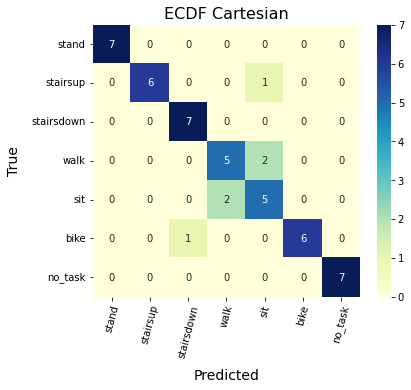

In [ ]:
conf_mat_plot(ecdf_cart, 'ECDF Cartesian')

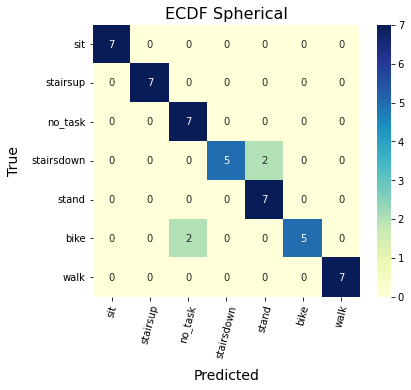

In [ ]:
conf_mat_plot(ecdf_spher, 'ECDF Spherical')

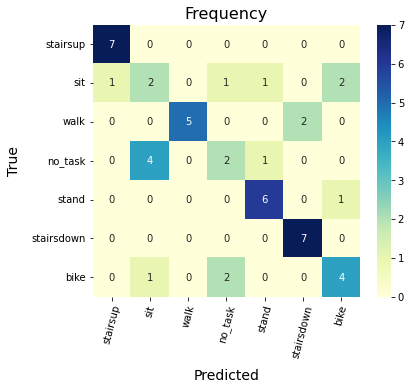

In [ ]:
conf_mat_plot(fft, 'Frequency')

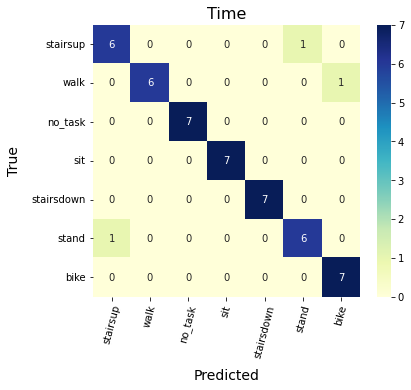

In [ ]:
conf_mat_plot(time_dom, 'Time')

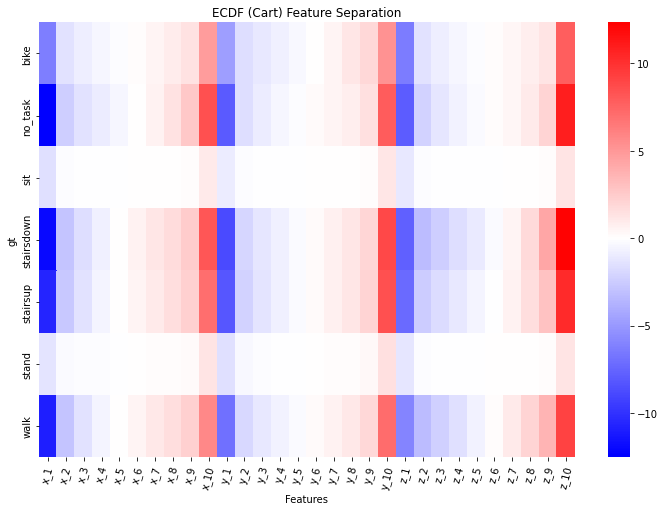

In [ ]:
#Feature separation

#Ecdf Cart
plt.figure(figsize=(12,8))
sns.heatmap(ecdf_cart.groupby('gt').mean(), center=0, cmap="bwr")
plt.xticks(rotation=75)
plt.xlabel('Features');
plt.title('ECDF (Cart) Feature Separation');

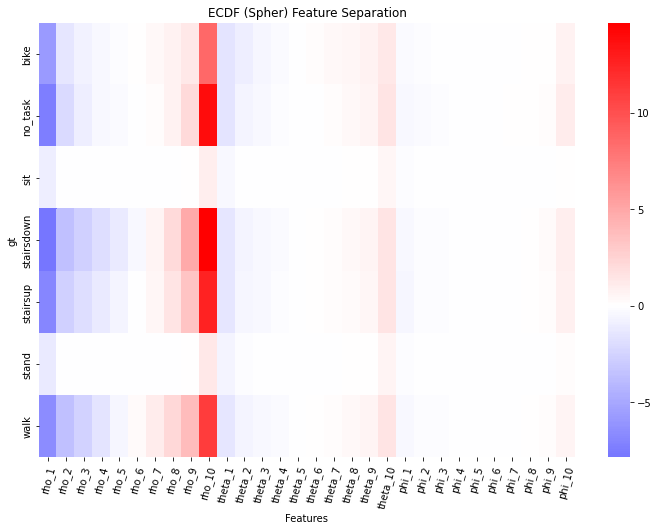

In [ ]:
#Ecdf spherical
plt.figure(figsize=(12,8))
sns.heatmap(ecdf_spher.groupby('gt').mean(), center=0, cmap="bwr")
plt.xticks(rotation=75)
plt.xlabel('Features');
plt.title('ECDF (Spher) Feature Separation');

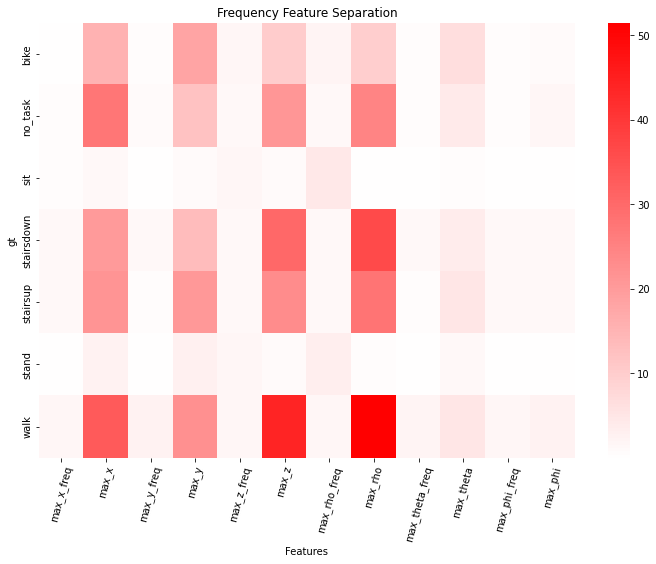

In [ ]:
#FFT
plt.figure(figsize=(12,8))
sns.heatmap(fft.groupby('gt').mean(), center=0, cmap="bwr")
plt.xticks(rotation=75)
plt.xlabel('Features');
plt.title('Frequency Feature Separation');

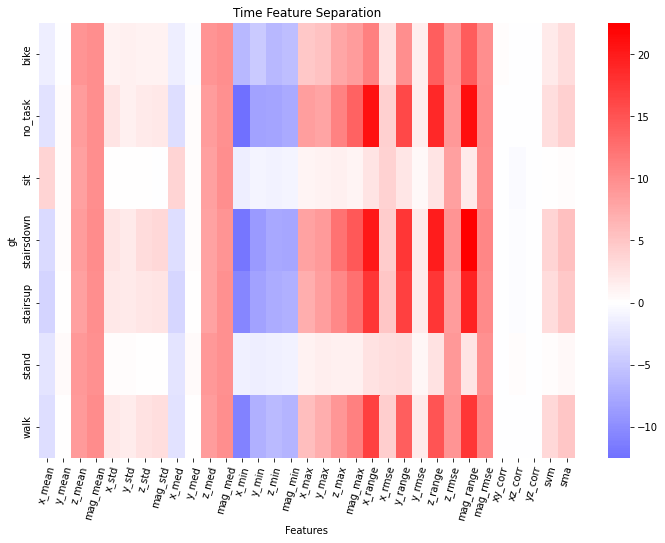

In [ ]:
#Time
plt.figure(figsize=(12,8))
sns.heatmap(time_dom.groupby('gt').mean(), center=0, cmap="bwr")
plt.xticks(rotation=75)
plt.xlabel('Features');
plt.title('Time Feature Separation');